<a href="https://colab.research.google.com/github/DaffaHamsy/SLO-tubes/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ................................................C=1; total time=   0.0s
[CV] END ................................................C=1; total time=   0.0s
[CV] END ................................................C=1; total time=   0.0s
[CV] END ................................................C=1; total time=   0.0s
[CV] END ................................................C=1; total time=   0.0s
[

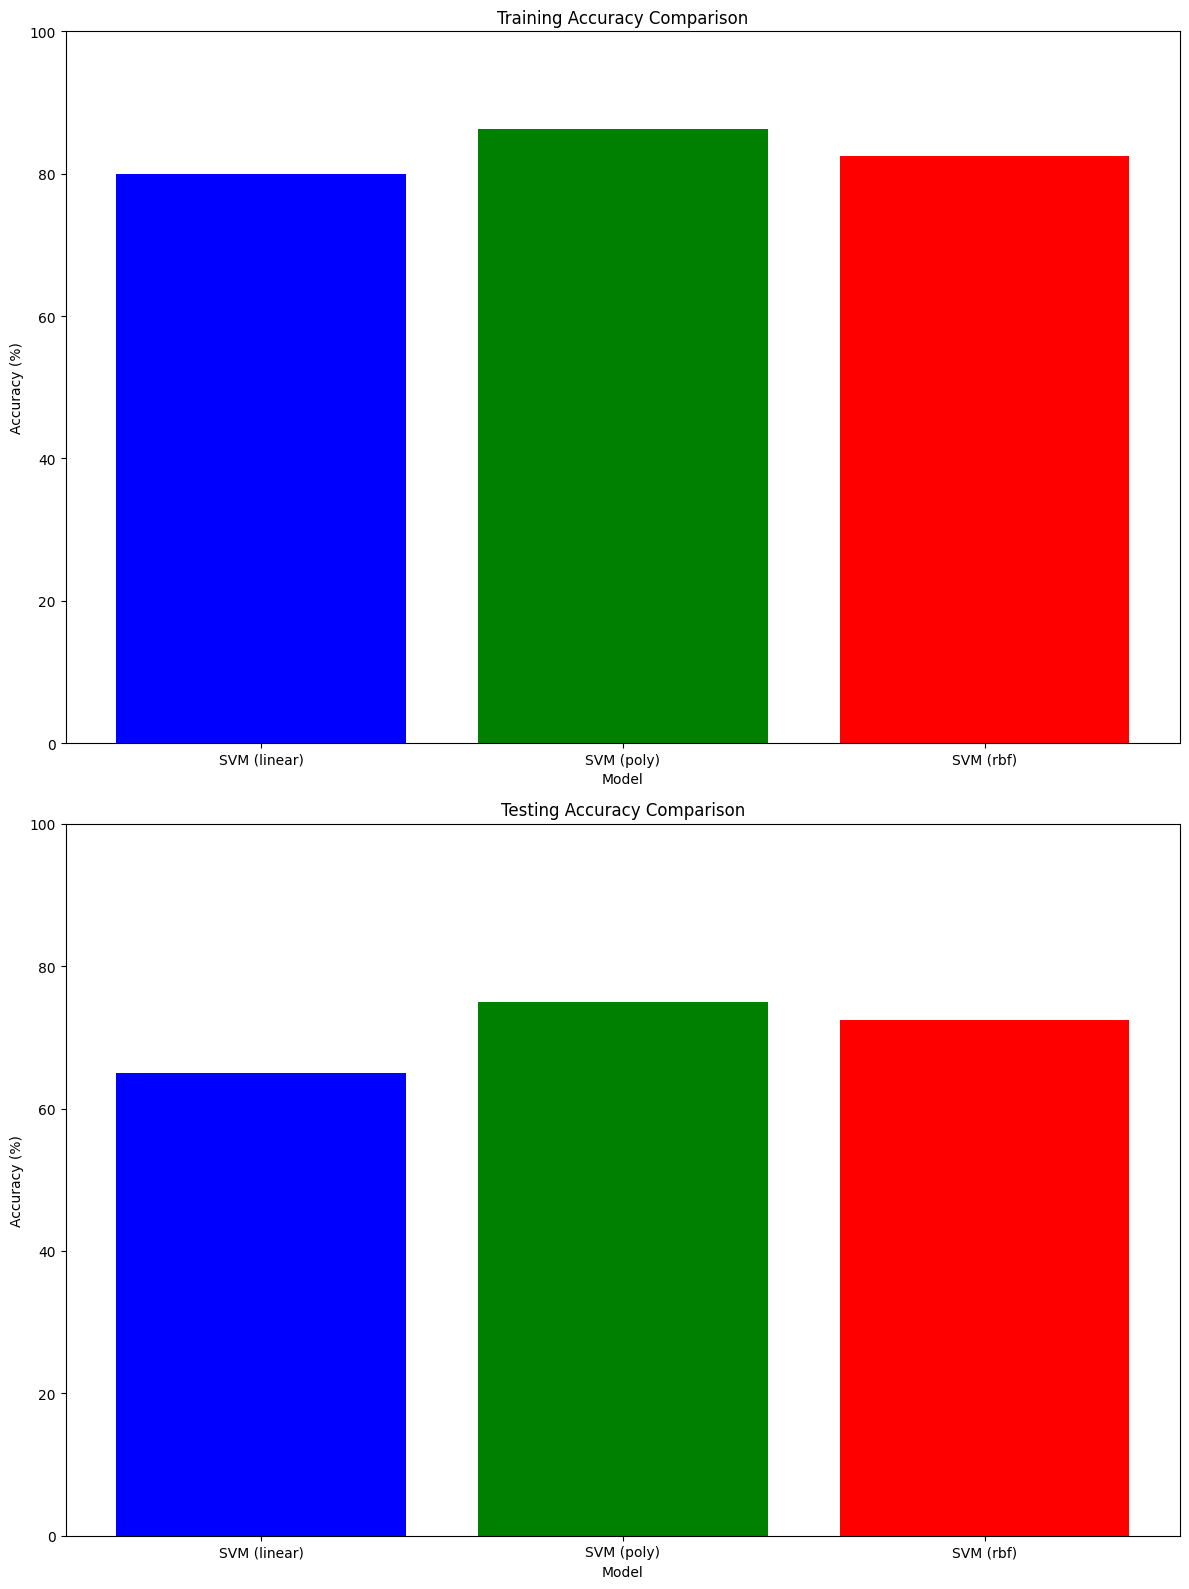

In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Load the Dataset
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Define the file path
file_path = '/content/drive/My Drive/Final Project/marketing_campaign.xlsx'

# Load the dataset
data = pd.read_excel(file_path)

# Step 3: Data Preprocessing
# Limit the dataset to a maximum of 100 entries per class randomly
data = data.groupby('Response').apply(lambda x: x.sample(n=min(len(x), 100), random_state=42)).reset_index(drop=True)

# Handle missing values
data = data.dropna()

# Drop date columns if present
if 'Dt_Customer' in data.columns:
    data = data.drop(columns=['Dt_Customer'])

# Select features and target
X = data.drop(columns=['Response'])
y = data['Response']

# Encode categorical features
X = pd.get_dummies(X, columns=['Education', 'Marital_Status'])

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Feature Selection using PCA
pca = PCA(n_components=10)
X = pca.fit_transform(X)

# Step 4: Apply Data Augmentation using SMOTE
# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Add random noise to the data
noise = np.random.normal(0, 0.01, X_resampled.shape)
X_noisy = X_resampled + noise

# Step 5: Train Multiple Models
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_noisy, y_resampled, test_size=0.2, random_state=42)

# Initialize and train models with different algorithms
models = {
    'SVM (linear)': SVC(kernel='linear'),
    'SVM (poly)': SVC(kernel='poly'),
    'SVM (rbf)': SVC(kernel='rbf')
}

param_grids = {
    'SVM (linear)': {'C': [0.1, 1, 10]},
    'SVM (poly)': {'C': [0.1, 1, 10], 'gamma': [0.1, 0.01], 'degree': [2, 3]},
    'SVM (rbf)': {'C': [0.1, 1, 10], 'gamma': [0.1, 0.01]}
}

results = {
    'train': {},
    'test': {}
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    param_grid = param_grids[model_name]
    grid = GridSearchCV(model, param_grid, refit=True, verbose=2, cv=skf)
    grid.fit(X_train, y_train)
    y_train_pred = grid.predict(X_train)
    y_test_pred = grid.predict(X_test)

    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred, average='macro') * 100
    recall_train = recall_score(y_train, y_train_pred, average='macro') * 100
    f1_train = f1_score(y_train, y_train_pred, average='macro') * 100

    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred, average='macro') * 100
    recall_test = recall_score(y_test, y_test_pred, average='macro') * 100
    f1_test = f1_score(y_test, y_test_pred, average='macro') * 100

    results['train'][model_name] = {
        'Precision': precision_train,
        'Recall': recall_train,
        'F-measure': f1_train,
        'Accuracy': accuracy_train * 100
    }
    results['test'][model_name] = {
        'Precision': precision_test,
        'Recall': recall_test,
        'F-measure': f1_test,
        'Accuracy': accuracy_test * 100
    }

# Convert results to DataFrame for better display
results_train_df = pd.DataFrame(results['train']).T
results_train_df = results_train_df.round(2)
results_test_df = pd.DataFrame(results['test']).T
results_test_df = results_test_df.round(2)

# Display the results
print("Training Results")
print(results_train_df)
print("\nTesting Results")
print(results_test_df)

# Step 6: Plot the Results
fig, axes = plt.subplots(2, 1, figsize=(12, 16))

# Bar plot for training accuracies
axes[0].bar(results_train_df.index, results_train_df['Accuracy'], color=['blue', 'green', 'red'])
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Training Accuracy Comparison')
axes[0].set_ylim(0, 100)

# Bar plot for testing accuracies
axes[1].bar(results_test_df.index, results_test_df['Accuracy'], color=['blue', 'green', 'red'])
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Testing Accuracy Comparison')
axes[1].set_ylim(0, 100)

plt.tight_layout()
plt.show()
